# Data fields
**ID - an Id that represents a (Shop, Item) tuple within the test set  
shop_id - unique identifier of a shop  
item_id - unique identifier of a product  
item_category_id - unique identifier of item category  
item_cnt_day - number of products sold. You are predicting a monthly amount of this measure  
item_price - current price of an item  
date - date in format dd/mm/yyyy  
date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,...,   October 2015 is 33  
item_name - name of item  
shop_name - name of shop  
item_category_name - name of item category**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [90]:
# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [2]:
path = './DataSets/competitive-data-science-predict-future-sales/'

# Train DF and Extra Infos

In [3]:
df_train = pd.read_csv(path+'sales_train.csv', dtype={'date_block_num':'int16','shop_id':'int16','item_id':'int16','item_price':np.float64, 'item_cnt_day':np.float32})
items = pd.read_csv(path+'items.csv', dtype={'item_id':'int32','item_category_id':'int32'})
shops = pd.read_csv(path+'shops.csv', dtype={'shop_id':'int32'})
category = pd.read_csv(path+'item_categories.csv', dtype={'item_category_id':'int32'})

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int16
shop_id           int16
item_id           int16
item_price        float64
item_cnt_day      float32
dtypes: float32(1), float64(1), int16(3), object(1)
memory usage: 72.8+ MB


# Test DF and Sample

In [5]:
df_test = pd.read_csv(path+'test.csv')
sample = pd.read_csv(path+'sample_submission.csv')

# 1.0 - Exploratory Data Analysis

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int16
shop_id           int16
item_id           int16
item_price        float64
item_cnt_day      float32
dtypes: float32(1), float64(1), int16(3), object(1)
memory usage: 72.8+ MB


In [7]:
## Check for NaN values
df_train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

## Check Prices

In [8]:
df_train[df_train.item_price==df_train.item_price.min()]
## One item with -1 on value

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [9]:
df_train[df_train.item_price==df_train.item_price.max()]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


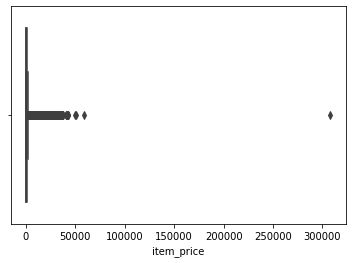

In [10]:
sns.boxplot(x=df_train.item_price)

**One huge outlier**

In [11]:
print('Price mean with outlier:',df_train.item_price.mean())
print("Price median with outlier:", df_train.item_price.median())

Price mean with outlier: 890.8532326979881
Price median with outlier: 399.0


In [12]:
## Drop this 2 rows (can fill with median too)
index = df_train[df_train.item_price==df_train.item_price.max()].index
index = df_train[df_train.item_price==df_train.item_price.min()].index
df_train.drop(index=index, inplace=True)

## Group Analysis

**date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33**

In [13]:
month_price = df_train.groupby(['date_block_num']).sum().drop(['shop_id','item_cnt_day','item_id'], axis=1).reset_index()

Text(0.5, 1.0, 'Revenue per Month')

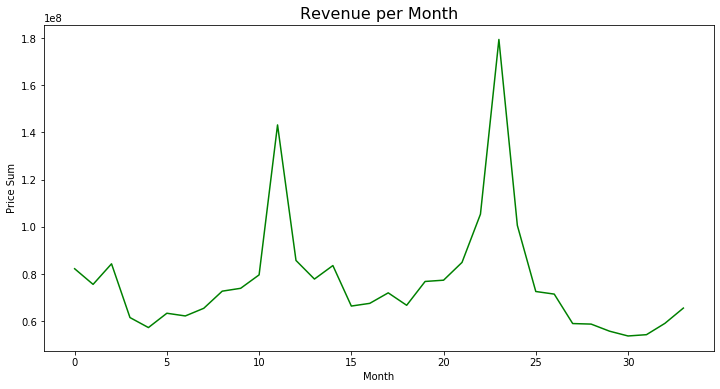

In [14]:
plt.figure(figsize=(12,6))
ax = sns.lineplot(x='date_block_num',y='item_price',data=month_price, color='green')
ax.set(xlabel='Month', ylabel='Price Sum')
ax.set_title('Revenue per Month', fontsize=16)

In [30]:
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [42]:
## Group by shop, month and item 
## A shop, one day and many items, each one has avg item_price (real item price) and amount of itens sold
month_sales = df_train.groupby(['shop_id','date_block_num','item_id']).agg({'item_price':'mean','item_cnt_day':'sum'})

In [43]:
month_sales.head()

item_price  item_cnt_day
shop_id date_block_num item_id                          
0       0              32            221.0           6.0
                       33            347.0           3.0
                       35            247.0           1.0
                       43            221.0           1.0
                       51            128.5           2.0

Text(0.5, 1.0, 'Count of itens per month')

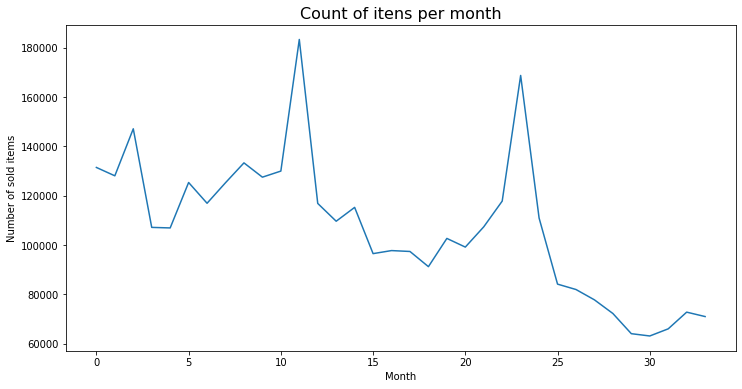

In [81]:
## Number of total sales per month
cnt_sales = df_train.groupby(['date_block_num']).sum().reset_index()
plt.figure(figsize=(12,6))
ax = sns.lineplot(x='date_block_num',y='item_cnt_day',data=cnt_sales)
ax.set(xlabel='Month', ylabel='Number of sold items')
ax.set_title('Count of itens per month', fontsize=16)

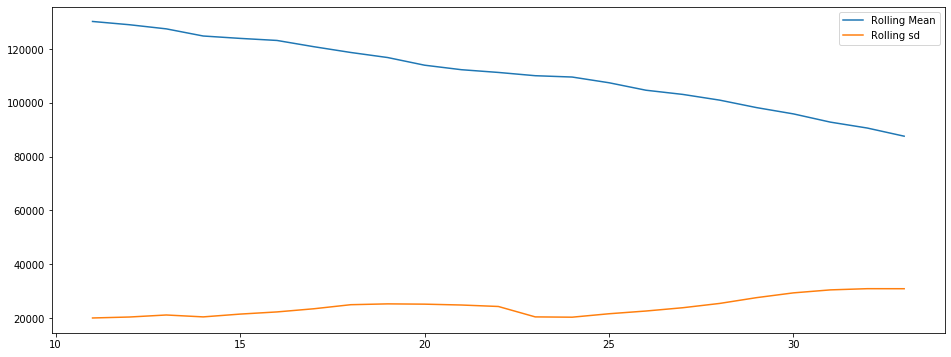

In [85]:
ts=df_train.groupby(["date_block_num"])["item_cnt_day"].sum()
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

In [87]:
import statsmodels.api as sm

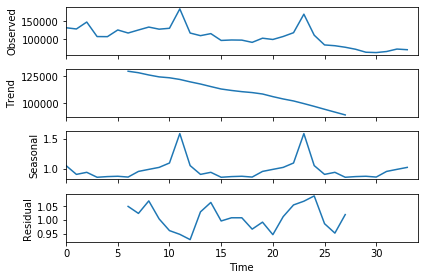

In [88]:
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
fig = res.plot()

In [91]:
# Stationarity tests
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                 -2.395708
p-value                         0.142951
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


In [92]:
# to remove trend
from pandas import Series as Series
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

In [93]:
ts=df_train.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)
plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts)
plt.plot(new_ts)
plt.plot()

plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts,12)       # assuming the seasonality is 12 months long
plt.plot(new_ts)
plt.plot()

NameError: name 'sales' is not defined